# Autoencoder for Binary Occupancy Detection (Segmented Data)

**Data Source**: Pre-segmented data from `datasets/03-tvat-segments`

**Goal**: Binary occupancy detection (NA vs any activity)

**Approach**: Train autoencoder on all activities, use reconstruction error threshold for classification

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)
from collections import Counter

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Load and Preprocess Segmented Data

Load from `datasets/03-tvat-segments`, drop guard bands, normalize

In [17]:
# Setup paths
segments_path = '../datasets/03-tvat-segments'
activities = ['JJ', 'LA', 'LL', 'NA', 'RA', 'RL', 'SO']

print(f"Loading data from: {segments_path}")
print(f"Activities: {activities}")

Loading data from: ../datasets/03-tvat-segments
Activities: ['JJ', 'LA', 'LL', 'NA', 'RA', 'RL', 'SO']


In [18]:
# Reload data with proper guard band handling
guard_bands = ['2', '3', '4', '5', '32', '59', '60', '61', '62', '63']

all_segments = []
all_labels = []

for activity in activities:
    activity_path = os.path.join(segments_path, activity)
    csv_files = [f for f in os.listdir(activity_path) if f.endswith('.csv')]
    
    for csv_file in csv_files:
        file_path = os.path.join(activity_path, csv_file)
        df = pd.read_csv(file_path, index_col=0)
        
        # Drop timestamp
        if 'timestamp' in df.columns:
            df = df.drop(columns=['timestamp'])
        
        # Drop guard bands (errors='ignore' for JJ which already has them dropped)
        df = df.drop(columns=guard_bands, errors='ignore')
        
        # Flatten the segment
        segment_flat = df.values.flatten()
        all_segments.append(segment_flat)
        all_labels.append(activity)

X = np.array(all_segments)
y = np.array(all_labels)

print(f"After guard band removal:")
print(f"Total segments: {len(X)}")
print(f"Segment shape: {X.shape}")
print(f"Features per segment: {X.shape[1]}")

# Normalize with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nData normalized to range [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")

After guard band removal:
Total segments: 1157
Segment shape: (1157, 10800)
Features per segment: 10800

Data normalized to range [0.000, 1.000]


# IGNORE THIS CELL - duplicate/old code
# ## 3. Data Preprocessing
# 
# Drop guard bands and normalize

In [19]:
# IGNORE THIS CELL - duplicate/old code
# # Check if we need to drop guard bands
# # Segmented data should have either 54 or 52 subcarriers per packet
# features_per_segment = X.shape[1]
# packets_per_segment = 200
# subcarriers = features_per_segment // packets_per_segment
# 
# print(f"Features per segment: {features_per_segment}")
# print(f"Subcarriers per packet: {subcarriers}")
# 
# # Note: JJ folder has pre-dropped guard bands (52 or 54 subcarriers)
# # Others may have 65 columns (64 + timestamp) or 64 columns
# # We'll handle heterogeneous shapes by padding/truncating if needed
# 
# # For now, let's check the actual shapes
# unique_shapes = set()
# for activity in activities:
#     activity_path = os.path.join(segments_path, activity)
#     csv_files = [f for f in os.listdir(activity_path) if f.endswith('.csv')]
#     if csv_files:
#         sample_df = pd.read_csv(os.path.join(activity_path, csv_files[0]), index_col=0)
#         if 'timestamp' in sample_df.columns:
#             sample_df = sample_df.drop(columns=['timestamp'])
#         unique_shapes.add((activity, sample_df.shape[1]))
# 
# print(f"\nShape per activity (after dropping timestamp):")
# for activity, cols in sorted(unique_shapes):
#     print(f"  {activity}: {cols} subcarriers")

In [20]:
# IGNORE THIS CELL - duplicate/old code
# # Reload data with proper guard band handling
# guard_bands = ['2', '3', '4', '5', '32', '59', '60', '61', '62', '63']
# 
# all_segments = []
# all_labels = []
# 
# for activity in activities:
#     activity_path = os.path.join(segments_path, activity)
#     csv_files = [f for f in os.listdir(activity_path) if f.endswith('.csv')]
#     
#     for csv_file in csv_files:
#         file_path = os.path.join(activity_path, csv_file)
#         df = pd.read_csv(file_path, index_col=0)
#         
#         # Drop timestamp
#         if 'timestamp' in df.columns:
#             df = df.drop(columns=['timestamp'])
#         
#         # Drop guard bands (errors='ignore' for JJ which already has them dropped)
#         df = df.drop(columns=guard_bands, errors='ignore')
#         
#         # Flatten the segment
#         segment_flat = df.values.flatten()
#         all_segments.append(segment_flat)
#         all_labels.append(activity)
# 
# X = np.array(all_segments)
# y = np.array(all_labels)
# 
# print(f"After guard band removal:")
# print(f"Total segments: {len(X)}")
# print(f"Segment shape: {X.shape}")
# print(f"Features per segment: {X.shape[1]} (should be 200 × 52-54 subcarriers)")
# 
# # Normalize with MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# 
# print(f"\nData normalized to range [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")

## 4. Data Splitting

80% train, 20% test (stratified by activity)

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print(f"\nTrain distribution: {dict(Counter(y_train))}")
print(f"Test distribution: {dict(Counter(y_test))}")

# Create binary labels (0=NA, 1=non-NA)
y_train_binary = np.array([0 if label == 'NA' else 1 for label in y_train])
y_test_binary = np.array([0 if label == 'NA' else 1 for label in y_test])

print(f"\nBinary distribution (test): NA={np.sum(y_test_binary==0)}, Occupied={np.sum(y_test_binary==1)}")

Training set: 925 samples
Test set: 232 samples

Train distribution: {np.str_('RA'): 145, np.str_('LA'): 117, np.str_('NA'): 144, np.str_('RL'): 116, np.str_('LL'): 141, np.str_('JJ'): 129, np.str_('SO'): 133}
Test distribution: {np.str_('LL'): 35, np.str_('RL'): 29, np.str_('JJ'): 32, np.str_('SO'): 34, np.str_('NA'): 36, np.str_('LA'): 29, np.str_('RA'): 37}

Binary distribution (test): NA=36, Occupied=196


## 5. Build Autoencoder

Simple architecture: Input → 256 → 64 → 256 → Output

In [22]:
input_dim = X_train.shape[1]
l2_reg = 1e-5
dropout_rate = 0.2

# Encoder
encoder_input = keras.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)

# Bottleneck
bottleneck = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name='bottleneck')(x)

# Decoder
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(bottleneck)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)

# Output
decoder_output = layers.Dense(input_dim, activation='linear')(x)

# Create model
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     2,765,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10800)          │     2,775,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,575,792 (21.27 MB)

 Trainable params: 5,574,768 (21.27 MB)

 Non-trainable params: 1,024 (4.00 KB)

## 6. Train Autoencoder

Train on all activities

In [23]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = autoencoder.fit(
    X_train, X_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save model
autoencoder.save('models/autoencoder_segmented.keras')
print("\nModel saved to models/autoencoder_segmented.keras")

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1176 - mae: 0.2854 - val_loss: 0.1022 - val_mae: 0.2425
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0786 - mae: 0.2308 - val_loss: 0.0696 - val_mae: 0.1968
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0390 - mae: 0.1406 - val_loss: 0.0521 - val_mae: 0.1631
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - mae: 0.0912 - val_loss: 0.0380 - val_mae: 0.1392
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - mae: 0.0827 - val_loss: 0.0394 - val_mae: 0.1418
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0184 - mae: 0.0799 - val_loss: 0.0246 - val_mae: 0.1070
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0169 - mae: 0.0750 - val_loss: 0.0215 - val_mae: 0.0951
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0163 - mae: 0.0741 - val_loss: 0.0176 - val_mae: 0.0819
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - lo

## 7. Visualize Training

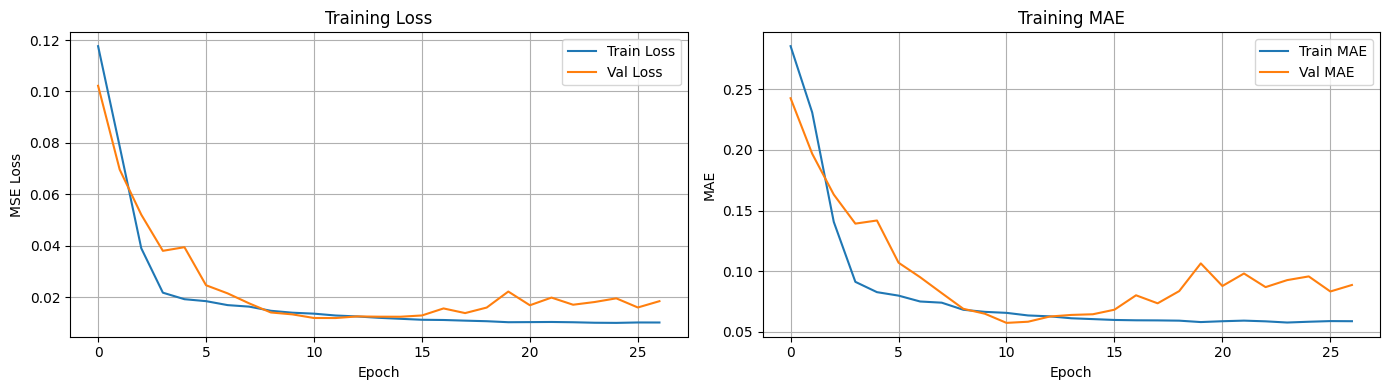

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 8. Reconstruction Error Analysis

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Reconstruction Error Statistics:
NA (Empty):       Mean=0.005641, Std=0.002352
Occupied:         Mean=0.007835, Std=0.003893
Difference:       0.002193


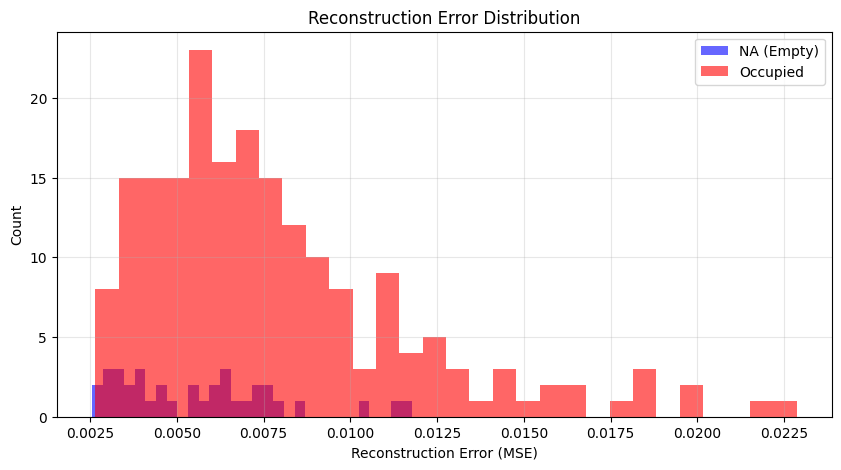

In [25]:
# Calculate reconstruction errors
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)

# Split by class
errors_na = reconstruction_errors[y_test_binary == 0]
errors_occupied = reconstruction_errors[y_test_binary == 1]

print(f"Reconstruction Error Statistics:")
print(f"NA (Empty):       Mean={errors_na.mean():.6f}, Std={errors_na.std():.6f}")
print(f"Occupied:         Mean={errors_occupied.mean():.6f}, Std={errors_occupied.std():.6f}")
print(f"Difference:       {errors_occupied.mean() - errors_na.mean():.6f}")

# Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(errors_na, bins=30, alpha=0.6, label='NA (Empty)', color='blue')
plt.hist(errors_occupied, bins=30, alpha=0.6, label='Occupied', color='red')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Find Optimal Threshold

ROC AUC: 0.6789
Optimal threshold: 0.007709
At optimal threshold: TPR=0.4133, FPR=0.1389


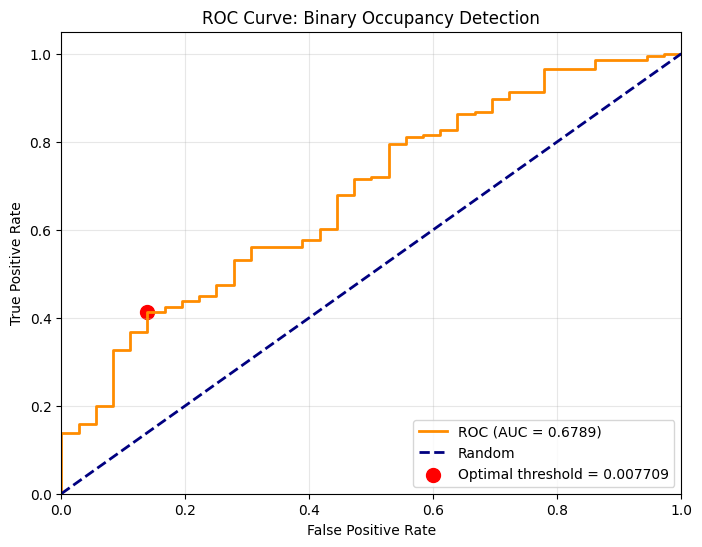

In [26]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Optimal threshold (maximize Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Optimal threshold: {optimal_threshold:.6f}")
print(f"At optimal threshold: TPR={tpr[optimal_idx]:.4f}, FPR={fpr[optimal_idx]:.4f}")

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
            label=f'Optimal threshold = {optimal_threshold:.6f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Binary Occupancy Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## 10. Final Evaluation


BINARY OCCUPANCY DETECTION - SEGMENTED DATA
Accuracy:  0.4784
Precision: 0.9412
Recall:    0.4082
F1 Score:  0.5694

Confusion Matrix:
                Predicted
                NA    Occupied
Actual NA       31     5     
Actual Occupied 116    80    

NA detection accuracy:       86.11%
Occupied detection accuracy: 40.82%


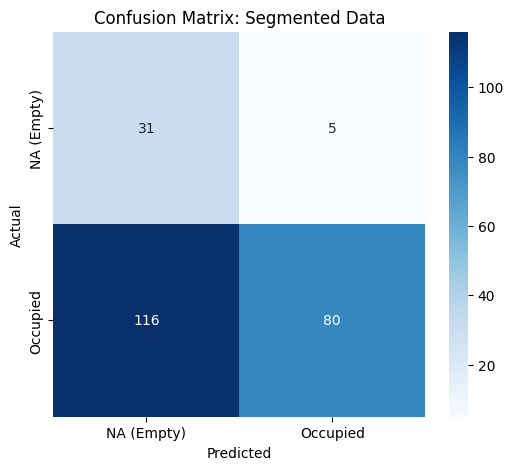

In [27]:
# Predict using optimal threshold
y_pred = (reconstruction_errors > optimal_threshold).astype(int)

# Metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print("\n" + "="*50)
print("BINARY OCCUPANCY DETECTION - SEGMENTED DATA")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("="*50)

# Confusion matrix
cm = confusion_matrix(y_test_binary, y_pred)
print("\nConfusion Matrix:")
print("                Predicted")
print("                NA    Occupied")
print(f"Actual NA       {cm[0,0]:<6} {cm[0,1]:<6}")
print(f"Actual Occupied {cm[1,0]:<6} {cm[1,1]:<6}")

# Per-class accuracy
na_accuracy = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
occupied_accuracy = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
print(f"\nNA detection accuracy:       {na_accuracy:.2%}")
print(f"Occupied detection accuracy: {occupied_accuracy:.2%}")

# Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NA (Empty)', 'Occupied'],
            yticklabels=['NA (Empty)', 'Occupied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Segmented Data')
plt.show()

## 11. Sample Predictions

In [28]:
# Show 10 random predictions
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), size=min(10, len(X_test)), replace=False)

print("\nSample Predictions:")
print("-" * 80)
print(f"{'Index':<8} {'Activity':<8} {'Actual':<12} {'Predicted':<12} {'Rec Error':<12} {'Correct'}")
print("-" * 80)

for idx in sample_indices:
    activity = y_test[idx]
    actual = 'NA' if y_test_binary[idx] == 0 else 'Occupied'
    predicted = 'NA' if y_pred[idx] == 0 else 'Occupied'
    error = reconstruction_errors[idx]
    correct = '✓' if actual == predicted else '✗'
    
    print(f"{idx:<8} {activity:<8} {actual:<12} {predicted:<12} {error:<12.6f} {correct}")

print("-" * 80)


Sample Predictions:
--------------------------------------------------------------------------------
Index    Activity Actual       Predicted    Rec Error    Correct
--------------------------------------------------------------------------------
219      RA       Occupied     NA           0.006874     ✗
66       NA       NA           NA           0.007556     ✓
9        SO       Occupied     Occupied     0.011884     ✓
170      SO       Occupied     Occupied     0.008947     ✓
15       LA       Occupied     NA           0.003540     ✗
201      JJ       Occupied     NA           0.005917     ✗
25       SO       Occupied     Occupied     0.009698     ✓
197      LA       Occupied     Occupied     0.008379     ✓
154      SO       Occupied     NA           0.006995     ✗
126      RL       Occupied     NA           0.006261     ✗
--------------------------------------------------------------------------------
